In [146]:
import torch
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import GCNConv
import torch.nn.functional as Fun
import pandas as pd
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator

In [147]:
tox= MoleculeNet(root='', name="Tox21")
data_frame = pd.DataFrame(tox.data.y.numpy())
tox.data.y = torch.Tensor(data_frame[7])
nan_indexes = torch.where(torch.isnan(tox.data.y) == False)[0]

# removed nan values 
tox_filtered = tox[nan_indexes]
filtered_y = tox.data.y[nan_indexes]

# split in train and test set 
f = int(len(tox_filtered)* 0.8)
tox_val = tox_filtered[f:len(tox_filtered)]

# oversampling for training set 
train_y =  filtered_y[0:f]
train_y_indexes = torch.where(train_y == 1)[0]
train_zeros = torch.where(train_y == 0)[0]

# TODO: replace with sampling 
train_indexes = torch.cat((train_y_indexes, train_y_indexes, train_y_indexes, train_y_indexes, train_y_indexes, train_y_indexes, train_zeros))

tox_train = tox_filtered[train_indexes]

tox.data.x =tox.data.x.float()


8485
1167
hi
764


In [148]:
class GNN(torch.nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv1 = GCNConv(9, 128)
        self.conv2 = GCNConv(128, 128)
        self.conv3 = GCNConv(128, 128)
        self.lin = torch.nn.Linear(128, 2)
        self.sig = torch.nn.Sigmoid()
    
    def forward(self, data): 
        e = data.edge_index
        x = data.x
        
        x = self.conv1(x, e)
        x = x.relu()
        x = self.conv2(x, e)
        x = x.relu()
        x = self.conv3(x, e)
        # x = Fun.relu(x)
        x = global_mean_pool(x, data.batch)  # [batch_size, hidden_channels]

        # x = Fun.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        #x = self.sig(x)
        return x

In [149]:
model = GNN()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
#loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([(5832-942)/942]))
loss = torch.nn.CrossEntropyLoss() #weight=torch.Tensor([1/6, 5/6]))

def training(loader): 
    model.train()

    current_loss = 0
    for d in loader: 
    # for batch in loader: 
        optimizer.zero_grad()
        d.x = d.x.float()
    
        out = model(d)
        
        l = loss(out, d.y.long())#torch.reshape(d.y, (len(d.y), 1)))
        current_loss += l 
        l.backward()
        optimizer.step()
    return current_loss / len(loader.batch_sampler)

In [150]:
# load datasets
train_loader = DataLoader(tox_train, batch_size=64, shuffle=True)
test_loader = DataLoader(tox_val, batch_size=64, shuffle=True)


In [151]:
def test(loader): 
    model.eval()
    correct = 0
    test_loss = 0
    for d in loader: 
        out = model(d)
        l = loss(out, d.y.long())
        test_loss += l
        pred = out.argmax(dim=1)
        y = d.y 
        correct += (pred == y).sum()
    return correct / len(test_loader.dataset), test_loss/len(loader.batch_sampler)

In [157]:
# function for plotting loss and accuracy 

def plot_hist2(hist):
    epochs, t_loss, t_acc, tpr, tnr, test_loss, test_acc = zip(*hist)
    plt.figure(figsize=(16, 6))
    plt.plot([1, 2])
    plt.subplot(121)
    plt.plot(epochs, t_acc, label="accuracy")
    # plt.plot(epochs, tpr, label=" TPR")
    # plt.plot(epochs, tnr, label=" TNR")
    plt.plot(epochs, test_acc, label=" val accuracy")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.title('Model Accuracy')
    plt.legend()
    plt.subplot(122)
    plt.plot(epochs, t_loss, label="training loss")
    plt.plot(epochs, test_loss, label="val loss")
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Model Loss')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

Epoch:0, Training loss: tensor(0.6668, grad_fn=<DivBackward0>), Test loss: tensor(0.8248, grad_fn=<DivBackward0>)
Accuracy: tensor(0.6055), Test accuracy: tensor(0.3728), TPR: tensor(0.8996), TNR: tensor(0.2598)
Epoch:10, Training loss: tensor(0.6445, grad_fn=<DivBackward0>), Test loss: tensor(0.7836, grad_fn=<DivBackward0>)
Accuracy: tensor(0.6154), Test accuracy: tensor(0.4336), TPR: tensor(0.8357), TNR: tensor(0.3581)
Epoch:20, Training loss: tensor(0.6283, grad_fn=<DivBackward0>), Test loss: tensor(0.6350, grad_fn=<DivBackward0>)
Accuracy: tensor(0.6610), Test accuracy: tensor(0.6144), TPR: tensor(0.7253), TNR: tensor(0.5851)
Epoch:30, Training loss: tensor(0.6133, grad_fn=<DivBackward0>), Test loss: tensor(0.6706, grad_fn=<DivBackward0>)
Accuracy: tensor(0.6671), Test accuracy: tensor(0.5716), TPR: tensor(0.7952), TNR: tensor(0.5178)
Epoch:40, Training loss: tensor(0.5993, grad_fn=<DivBackward0>), Test loss: tensor(0.5544, grad_fn=<DivBackward0>)
Accuracy: tensor(0.6796), Test acc

/var/folders/9p/vmw7ktwj05v2jfcjtj798dcw0000gn/T/ipykernel_55472/3193489350.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


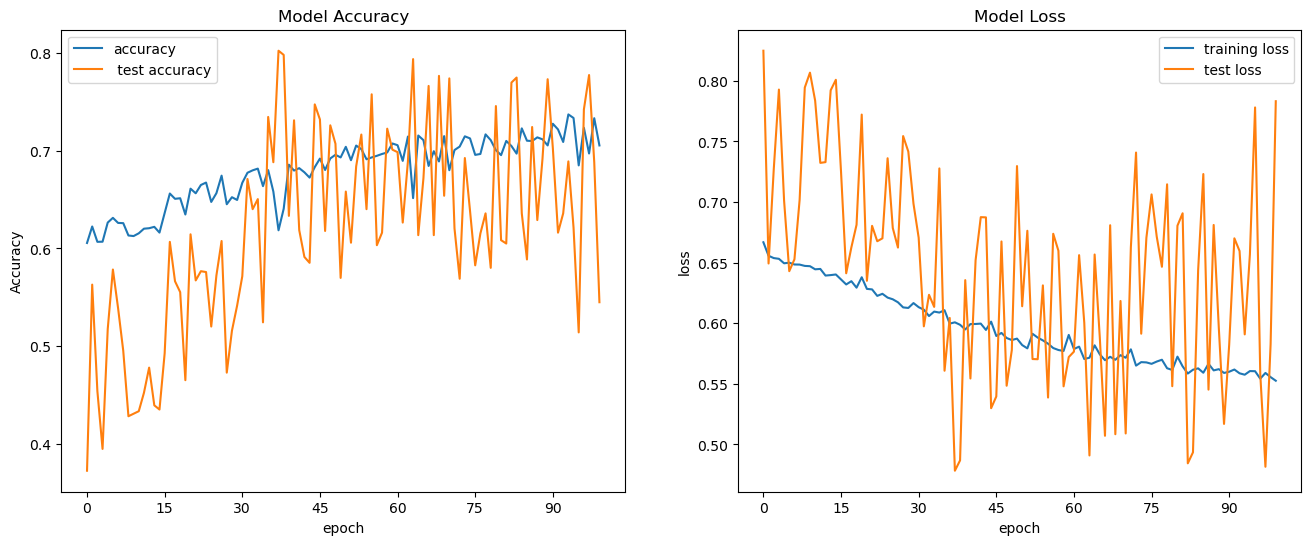

In [155]:
# calling the training, calculating accuracy, true positive rate and true negative rate

hist_data = []
for epoch in range(100): 
    epoch_loss = training(train_loader)
    test_acc, test_loss = test(test_loader)
    correct = 0
    tpr = 0
    tnr = 0
    for d in train_loader: 
        out = model(d)
        # pred = torch.round(out)
        pred = out.argmax(dim=1)
        y = d.y #torch.reshape(d.y, (len(d.y), 1))
        correct += (pred == y).sum()
        temp = ((pred == y) & (pred == 1)).sum()
        tnr += ((((pred == y) & (pred == 0)).sum() / (y == 0).sum()))
        if temp==0: 
            continue
        tpr += (((pred == y) & (pred == 1)).sum() / (y == 1).sum())
    hist_data.append([epoch, epoch_loss.detach().numpy(), (torch.Tensor([correct / len(train_loader.dataset)])).detach().numpy(), (torch.Tensor([tpr/len(train_loader.batch_sampler)])).detach().numpy(), (tnr/len(train_loader.batch_sampler)).detach().numpy(), test_loss.detach().numpy(), (torch.Tensor([test_acc])).detach().numpy()])
    
    if epoch % 10 == 0: 
        print("Epoch:" + str(epoch) + ", Training loss: " + str(epoch_loss) + ", Test loss: " + str(test_loss))
        print("Accuracy: " + str(correct / len(train_loader.dataset)) + ", Test accuracy: " + str(test_acc) + ", TPR: " + str(tpr/len(train_loader.batch_sampler)) + ", TNR: " + str(tnr/len(train_loader.batch_sampler)))

plot_hist2(hist_data)

/var/folders/9p/vmw7ktwj05v2jfcjtj798dcw0000gn/T/ipykernel_55472/1070871917.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


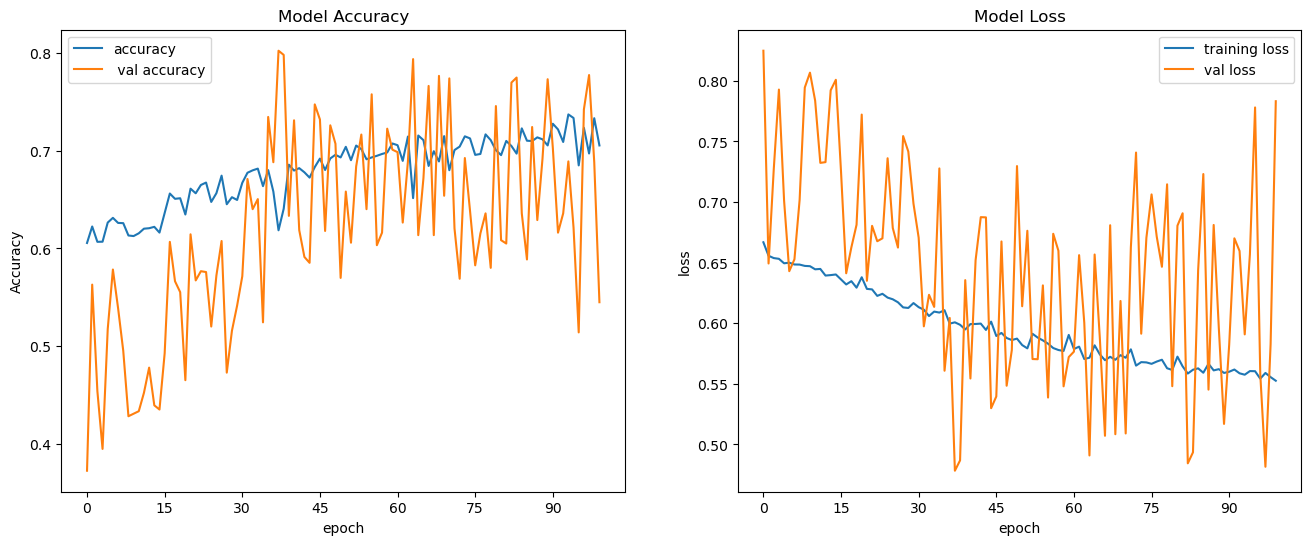

In [158]:
plot_hist2(hist_data)